# Experiments and Graphs for KDD

In [1]:
library(data.table)
library(tidyverse)
library(distr)
library(DescTools)
library(DirichletReg)
library(extraDistr)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Loading required package: startupmsg

Utilities for Start-Up Messages (version 0.9.6)

For more information see ?"startupmsg", NEWS("startupmsg")


Loading required pa

## Load in data

### Loading Amazon dataset

In [2]:
raw_df = read.csv("data/Video_Games_raw.csv", header = FALSE, col.names=c("item", "user", "rating", "timestamp"))

In [3]:
set.seed(1729)

df <- count(raw_df, item)
df <- merge(raw_df, df, by='item')
temp_df <- group_by(df, item) %>% summarize(avg = mean(rating))
df <- merge(df, temp_df, by='item')

in.train = sample(unique(df$item), size = 0.6*length(unique(df$item)))
amazon_df.train = filter(df, item %in% in.train)
amazon_df.test = filter(df, !item %in% in.train)
amazon_df <- df

In [4]:
amazon_df.test <- filter(amazon_df.test, n >= 100) %>%
  group_by(item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=100)

#split test set in half
amazon_df.test_learn = group_by(amazon_df.test, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=50)
amazon_df.test_eval = group_by(amazon_df.test, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_tail(n=50)

# set up evaluation dataset for evaluating
amazon_df.test_eval <- dcast(setDT(amazon_df.test_eval), item ~ rating, fun.aggregate = length) %>% arrange(item)
colnames(amazon_df.test_eval) <- c("item", "n1", "n2", "n3", "n4", "n5")
amazon_df.test_eval$n = amazon_df.test_eval$"n1" + amazon_df.test_eval$"n2" + amazon_df.test_eval$"n3" + amazon_df.test_eval$"n4" + amazon_df.test_eval$"n5"
amazon_df.test_eval <- transmute(amazon_df.test_eval, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

num_eval_products = nrow(amazon_df.test_eval)

amazon_df.test_learn_copy = amazon_df.test_learn
amazon_df.test_eval_copy = amazon_df.test_eval

### Loading synthetic data

In [5]:
TRUE_DIST = c(1,1,1,1,1)

set.seed(1729)

users <- rdirichlet(10000, TRUE_DIST)

In [6]:
mod_dgp <- function(alpha) {
    num = rpois(1, alpha %*% c(1,2,3,4,5) * 100/3)
    rcat(num, alpha)
}

dgp <- function(alpha) {
    rcat(100, alpha)
}

In [7]:
df <- apply(users, 1, dgp)
avg = apply(df, 2, mean)
temp <- as.data.frame(t(df))
colnames(temp) <- 1:100
df <- tibble(temp,avg)
df <- mutate(df, ID = row_number())
setDT(df)

unif_df <- melt(data = df, id.vars = c('avg', 'ID'), variable.name='timestamp', value.name='rating')
unif_df$timestamp <- as.numeric(unif_df$timestamp)

set.seed(1729)

in.train = sample(unique(unif_df$ID), size = 0.6*length(unique(unif_df$ID)))
unif_df.train = filter(unif_df, ID %in% in.train)
unif_df.test = filter(unif_df, !ID %in% in.train)
unif_df.train <- rename(unif_df.train, item = ID)

In [8]:
unif_df.test <- merge(unif_df.test, count(unif_df.test, ID), by='ID')

unif_df.test <- filter(unif_df.test, n >= 100) %>%
  group_by(ID) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=100)

unif_df.test <- rename(unif_df.test, item = ID)

#split test set in half
unif_df.test_learn = group_by(unif_df.test, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=50)
unif_df.test_eval = group_by(unif_df.test, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_tail(n=50)

# set up evaluation dataset
unif_df.test_eval <- dcast(setDT(unif_df.test_eval), item ~ rating, fun.aggregate = length) %>% arrange(item)
colnames(unif_df.test_eval) <- c("item", "n1", "n2", "n3", "n4", "n5")
unif_df.test_eval$n = unif_df.test_eval$"n1" + unif_df.test_eval$"n2" + unif_df.test_eval$"n3" + unif_df.test_eval$"n4" + unif_df.test_eval$"n5"
unif_df.test_eval <- transmute(unif_df.test_eval, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

unif_num_eval_products = nrow(unif_df.test_eval)

unif_df.test_learn_copy = unif_df.test_learn
unif_df.test_eval_copy = unif_df.test_eval


In [9]:
TRUE_DIST = c(1,1,1,1,1)

set.seed(1729)

users <- rdirichlet(10000, TRUE_DIST)

In [10]:
df = apply(users[1:10000,], 1, mod_dgp)

tall_data = data.frame(matrix(ncol=4, nrow=0))
for (i in 1:length(df)) {
    data = df[[i]]
    avg = mean(data)
    counts = 1:length(data)
    
    tall_data = rbind(tall_data, tibble(avg, i, counts, data))
}
colnames(tall_data) <- c('avg', 'ID', 'timestamp', 'rating')
df <- tall_data
setDT(df)

scaled_df <- df

set.seed(1729)

in.train = sample(unique(scaled_df$ID), size = 0.6*length(unique(scaled_df$ID)))
scaled_df.train = filter(scaled_df, ID %in% in.train)
scaled_df.test = filter(scaled_df, !ID %in% in.train)
scaled_df.train <- rename(scaled_df.train, item = ID)

In [11]:
scaled_df.test <- merge(scaled_df.test, count(scaled_df.test, ID), by='ID')

scaled_df.test <- filter(scaled_df.test, n >= 100) %>%
  group_by(ID) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=100)

scaled_df.test <- rename(scaled_df.test, item = ID)

#split test set in half
scaled_df.test_learn = group_by(scaled_df.test, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=50)
scaled_df.test_eval = group_by(scaled_df.test, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_tail(n=50)

# set up evaluation dataset
scaled_df.test_eval <- dcast(setDT(scaled_df.test_eval), item ~ rating, fun.aggregate = length) %>% arrange(item)
colnames(scaled_df.test_eval) <- c("item", "n1", "n2", "n3", "n4", "n5")
scaled_df.test_eval$n = scaled_df.test_eval$"n1" + scaled_df.test_eval$"n2" + scaled_df.test_eval$"n3" + scaled_df.test_eval$"n4" + scaled_df.test_eval$"n5"
scaled_df.test_eval <- transmute(scaled_df.test_eval, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

scaled_num_eval_products = nrow(scaled_df.test_eval)

scaled_df.test_learn_copy = scaled_df.test_learn
scaled_df.test_eval_copy = scaled_df.test_eval

## Fitting EB priors

In [12]:
fp_step <- function(alphas, log_p, N) {
  return(igamma(rep(digamma(sum(alphas)), 5) + log_p/N))
}

fit_prior <- function(df.train) {
    prior_df <- dcast(setDT(df.train), item ~ rating, fun.aggregate = length)

    colnames(prior_df) <- c("item", "n1", "n2", "n3", "n4", "n5")

    prior_df$n = prior_df$n1 + prior_df$n2 + prior_df$n3 + prior_df$n4 + prior_df$n5

    prior_df <- filter(prior_df, n >= 20)

    # remove all columns with a 0 count for one category
    prior_df  <- transmute(prior_df, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n) %>% 
      filter(n1 != 0 & n2 != 0 & n3 != 0 & n4 != 0 & n5 != 0)

    log_p <- summarize(prior_df, summarize(prior_df, n1 = sum(log(n1)), n2 = sum(log(n2)), n3 = sum(log(n3)), n4=sum(log(n4)), n5=sum(log(n5))))
    log_p <- as.numeric(log_p[1,])

    N <- nrow(prior_df)

    # start from a totally uninformed prior
    alphas = c(1,1,1,1,1)
    alphas <- fp_step(alphas, log_p, N)
    for (i in c(1:100)) {
        alphas <- fp_step(alphas,log_p,N)
    }
    print(alphas)
    alphas
}

In [13]:
amazon_alphas = fit_prior(amazon_df.train)
unif_alphas = fit_prior(unif_df.train)
scaled_alphas = fit_prior(scaled_df.train)

[1] 2.000377 1.304987 1.776889 2.958382 8.056539
[1] 1.126210 1.138256 1.152854 1.163658 1.139454
[1] 1.108831 1.128960 1.160082 1.182148 1.177479


## Generate graphs

### Figure 1

In [14]:
amazon_fig_1 = distinct(select(filter(amazon_df, n >= 20), c(item, avg)))
amazon_fig_1$ds = 'amazon'
colnames(amazon_fig_1) <- c('ID', 'avg', 'ds')

unif_fig_1 = distinct(select(unif_df, c('ID', 'avg')))
unif_fig_1$ds = 'uniform'

scaled_fig_1 = distinct(select(scaled_df, c('ID', 'avg')))
scaled_fig_1$ds = 'scaled'

fig_1_df = rbind(amazon_fig_1, unif_fig_1, scaled_fig_1)

In [15]:
options(repr.plot.width=8, repr.plot.height=8)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



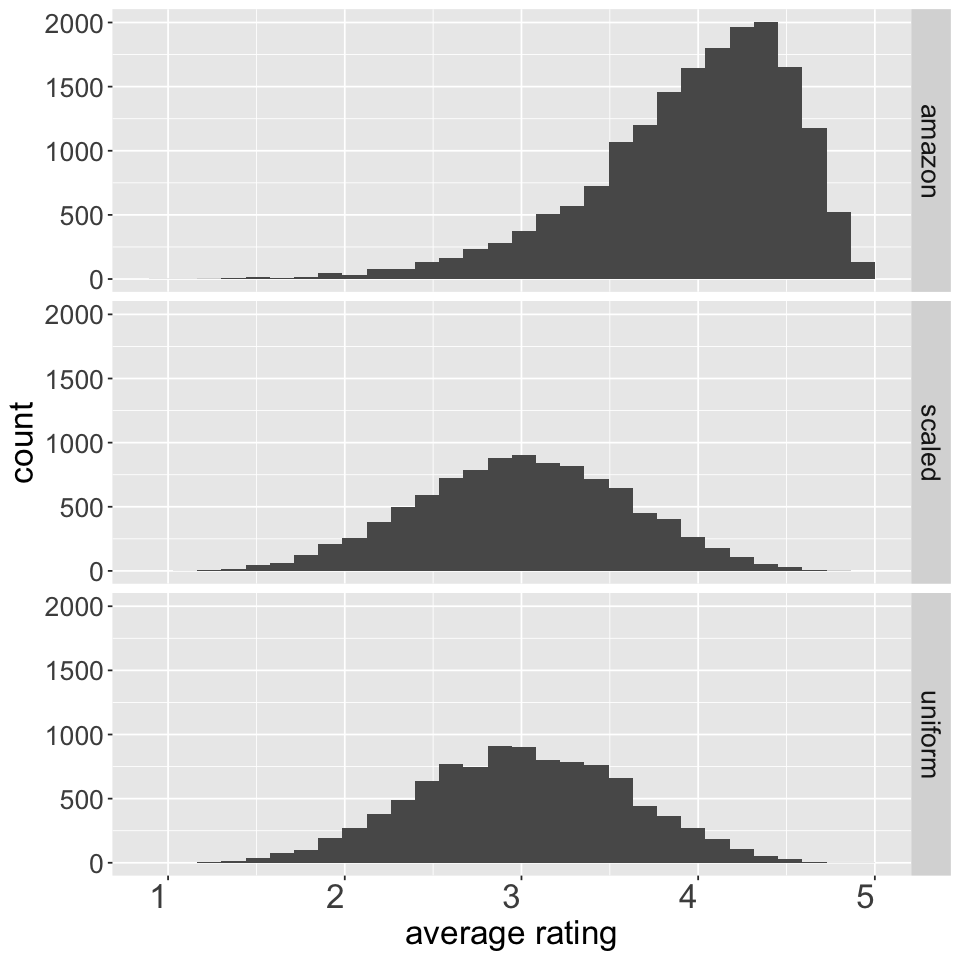

In [16]:
ggplot(fig_1_df) + geom_histogram(aes(x=avg)) + 
    facet_grid(rows = vars(ds)) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(size=20, angle=0, hjust=1)) +
        xlab("average rating")

## Figure 2

In [17]:
get_overtime_perf <- function(df.test_learn, df.test_eval, alphas) {
# start training and checking performance at each step
    items = unique(df.test_learn$item)

    mses_f = tibble(items)
    mses_b = tibble(items)

    for (i in c(1:50)) {
      df.test_learn_subset = group_by(df.test_learn, item) %>%
        arrange(timestamp, .by_group = TRUE) %>%
        slice_head(n=i)

      df.test_learn_subset <- dcast(setDT(df.test_learn_subset), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)

      # adding missing columns
      for (j in setdiff(c("item", "1", "2", "3", "4", "5"), colnames(df.test_learn_subset))) {
        df.test_learn_subset[[j]] <- rep(0, num_eval_products)
      }
      df.test_learn_subset <- df.test_learn_subset[,c("item", "1", "2", "3", "4", "5")]

      colnames(df.test_learn_subset) <- c("item", "n1", "n2", "n3", "n4", "n5")
      df.test_learn_subset$n = df.test_learn_subset$"n1" + df.test_learn_subset$"n2" + df.test_learn_subset$"n3" + df.test_learn_subset$"n4" + df.test_learn_subset$"n5"

      df.test_learn_f <- transmute(df.test_learn_subset, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)
      df.test_learn_b <- mutate(df.test_learn_subset, item=item, b1 = n1 + alphas[1], b2 = n2 + alphas[2], b3 = n3 + alphas[3],
             b4 = n4 + alphas[4], b5 = n5 + alphas[5], b = n + sum(alphas))

      df.test_learn_b <- mutate(df.test_learn_b, b1 = b1 / b, b2 = b2 / b, b3 = b3 / b, b4 = b4 / b, b5 = b5 / b)

      # prep datasets for evaluation
      df.test_eval_modified <- select(df.test_eval, c(n1, n2, n3, n4, n5))
      df.test_learn_b <- select(df.test_learn_b, c(b1, b2, b3, b4, b5))
      df.test_learn_f <- select(df.test_learn_f, c(n1, n2, n3, n4, n5))
        
      f_mse = rowSums((df.test_learn_f - df.test_eval_modified)^2)
      b_mse = rowSums((df.test_learn_b - df.test_eval_modified)^2)
      mses_f[[i]] = f_mse
      mses_b[[i]] = b_mse

    }

    mses_f = tibble(val = colSums(mses_f) / nrow(df.test_eval), method = "freq", idx=c(1:length(mses_f)))
    mses_b = tibble(val = colSums(mses_b) / nrow(df.test_eval), method = "eb", idx=c(1:length(mses_b)))

    mses = rbind(mses_f,mses_b)
    mses
}



In [18]:
amazon_fig_2 <- get_overtime_perf(amazon_df.test_learn, amazon_df.test_eval, amazon_alphas)
amazon_fig_2$ds = 'amazon'
unif_fig_2 <- get_overtime_perf(unif_df.test_learn, unif_df.test_eval, unif_alphas)
unif_fig_2$ds = 'uniform'
scaled_fig_2 <- get_overtime_perf(scaled_df.test_learn, scaled_df.test_eval, scaled_alphas)
scaled_fig_2$ds = 'scaled'

In [19]:
fig_2_df = rbind(amazon_fig_2, unif_fig_2, scaled_fig_2)

colnames(fig_2_df) <- c('error', 'method', 'num_train', 'ds')

In [20]:
options(repr.plot.width=9, repr.plot.height=12)

In [21]:
rename_method <- function(x) {
    if (x=='freq') {
        'frequentist'
    } else if (x=='eb') {
        'EB'
    } else {
        'N/A'
    }
}

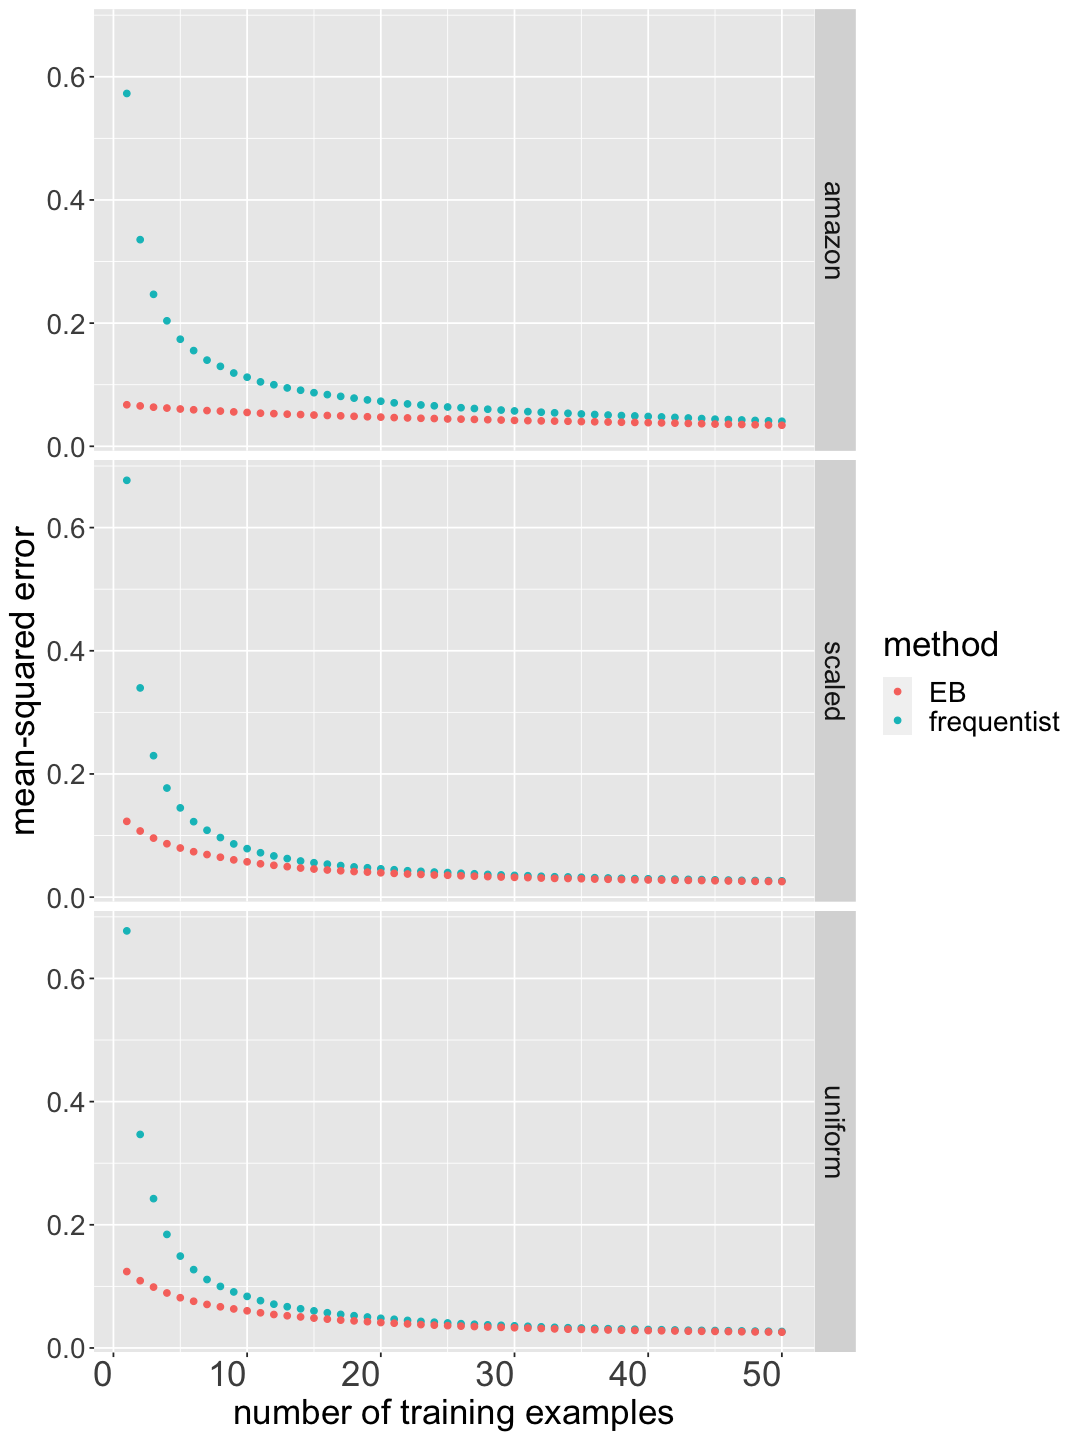

In [22]:
ggplot(mutate(fig_2_df, method=as.character(lapply(method, rename_method)))) + geom_point(aes(x=num_train, y=error, color=method)) + 
    facet_grid(row=vars(ds)) +    
    theme(text = element_text(size=21),
        axis.title = element_text(size=21),
        axis.text.x = element_text(size=21, angle=0, hjust=1)) +
        xlab("number of training examples") + ylab("mean-squared error")

## Figure 3

In [23]:
get_overaverage_perf <- function (df.test, df.test_learn, df.test_eval, alphas) {
    alphas_b <- alphas/sum(alphas)
    test_learn_agg <- dcast(setDT(df.test), item ~ rating, fun.aggregate = length)
    colnames(test_learn_agg) <- c('item', 'n1', 'n2', 'n3', 'n4', 'n5')
    test_learn_agg <- test_learn_agg %>% mutate(n = n1 + n2 + n3 + n4 + n5)
    test_learn_agg <- transmute(test_learn_agg, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

    test_subset = test_learn_agg %>% mutate(avg = (n1+2*n2+3*n3+4*n4+5*n5))

    results_df = data.frame(matrix(ncol=5,nrow=0))

    for (i in c(1, 3, 5, 10, 50)) {
      df.test_learn_subset = group_by(df.test_learn, item) %>%
        filter(item %in% test_subset$item) %>%
        arrange(timestamp, .by_group = TRUE) %>%
        slice_head(n=i)

      df.test_learn_subset <- dcast(setDT(df.test_learn_subset), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)

      # adding missing columns
      for (j in setdiff(c("item", "1", "2", "3", "4", "5"), colnames(df.test_learn_subset))) {
        df.test_learn_subset[[j]] <- rep(0, nrow(df.test_eval))
      }
      df.test_learn_subset <- df.test_learn_subset[,c("item", "1", "2", "3", "4", "5")]

      colnames(df.test_learn_subset) <- c("item", "n1", "n2", "n3", "n4", "n5")
      df.test_learn_subset$n = df.test_learn_subset$"n1" + df.test_learn_subset$"n2" + df.test_learn_subset$"n3" + df.test_learn_subset$"n4" + df.test_learn_subset$"n5"

      df.test_learn_f <- transmute(df.test_learn_subset, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)
      df.test_learn_b <- mutate(df.test_learn_subset, item=item, b1 = n1 + alphas[1], b2 = n2 + alphas[2], b3 = n3 + alphas[3],
             b4 = n4 + alphas[4], b5 = n5 + alphas[5], b = n + sum(alphas))
      df.test_learn_b <- transmute(df.test_learn_b, item=item, b1 = b1 / b, b2 = b2 / b, b3 = b3 / b, b4 = b4 / b, b5 = b5 / b)

      for (id in unique(test_subset$item)) {
          dist_b = filter(df.test_learn_b, item==id) %>% select(c(b1, b2, b3, b4, b5))
          dist_f = filter(df.test_learn_f, item==id) %>% select(c(n1, n2, n3, n4, n5))
          av = filter(test_subset, item==id)$avg
          dist_eval = filter(df.test_eval, item==id) %>% select(c(n1, n2, n3, n4, n5))

          to_add = c(id, sqrt(sum((dist_eval-dist_b)^2)), drop(av), i, 'eb')

          results_df <- rbind(results_df, to_add)

          to_add = c(id, sqrt(sum((dist_eval-dist_f)^2)), drop(av), i, 'freq')

          results_df <- rbind(results_df, to_add)

          to_add = c(id, sqrt(sum((dist_eval-alphas_b)^2)), drop(av), i, 'baseline')

          results_df <- rbind(results_df, to_add)

      }

    }

    colnames(results_df) <- c('item', 'dist', 'avg', 'num_train', 'method')
    results_df$dist <- as.numeric(results_df$dist)
    results_df$avg <- as.numeric(results_df$avg)
    results_df$num_train <- as.numeric(results_df$num_train)
    results_df
}



In [24]:
unif_fig_3 <- get_overaverage_perf(unif_df.test, unif_df.test_learn, unif_df.test_eval, unif_alphas)
amazon_fig_3 <- get_overaverage_perf(amazon_df.test, amazon_df.test_learn, amazon_df.test_eval, amazon_alphas)
scaled_fig_3 <- get_overaverage_perf(scaled_df.test, scaled_df.test_learn, scaled_df.test_eval, scaled_alphas)

In [25]:
scaled_fig_3$dist <- as.numeric(scaled_fig_3$dist)
scaled_fig_3$avg <- as.numeric(scaled_fig_3$avg)
scaled_fig_3$num_train <- as.numeric(scaled_fig_3$num_train)

In [26]:
get_avg_df <- function(results_df) {
        results_df %>% 
          mutate(level=round(avg*2)/2) %>%
          # mutate(level=floor(avg)) %>%
          group_by(level, method, num_train) %>%
          summarize(mean_dist=mean(dist), std = sd(dist), n=dplyr::n())
    }

In [27]:
unif_fig_3_avg <- get_avg_df(unif_fig_3)
unif_fig_3_avg$ds <- 'uniform'
amazon_fig_3_avg <- get_avg_df(amazon_fig_3)
amazon_fig_3_avg$ds <- 'amazon'
scaled_fig_3_avg <- get_avg_df(scaled_fig_3)
scaled_fig_3_avg$ds <- 'scaled'

`summarise()` has grouped output by 'level', 'method'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'level', 'method'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'level', 'method'. You can override using the `.groups` argument.



In [28]:
options(repr.plot.width=14, repr.plot.height=6)

In [29]:
fig_3_df = rbind(amazon_fig_3_avg, unif_fig_3_avg, scaled_fig_3_avg)
# colnames(fig_3_df) <- c('X', 'error', 'avg', 'num_train', 'method', 'ds')
colnames(fig_3_df) <- c('level', 'method', 'num_train', 'error', 'std', 'n', 'ds')
plot_fig_3_df <- (mutate(fig_3_df, method=as.character(lapply(method, rename_method))))

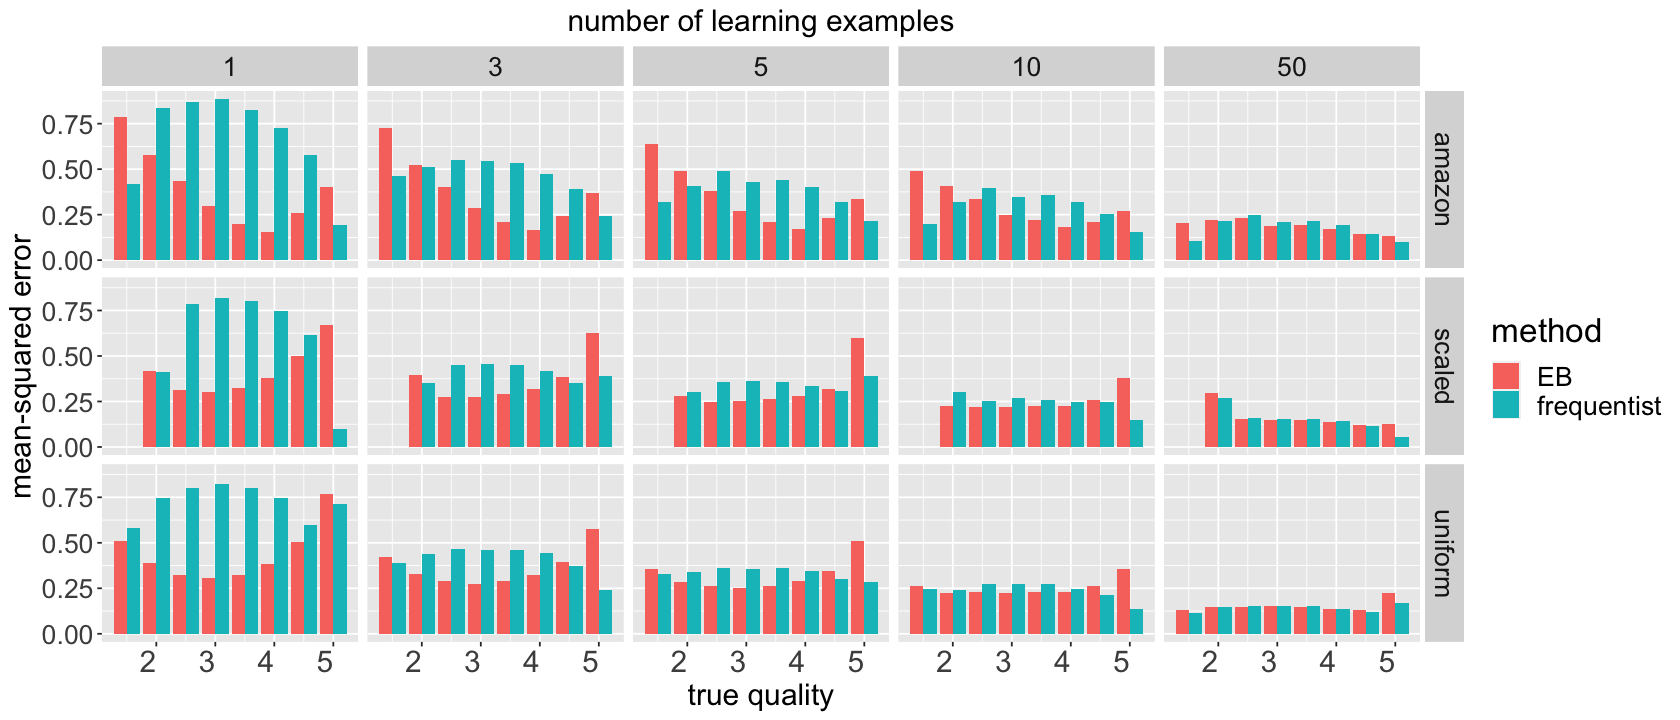

In [30]:
ggplot(filter(plot_fig_3_df, method %in% c('EB', 'frequentist'), num_train != 20)) + 
    geom_bar(aes(x=level,y=error,fill=method), position='dodge', stat='identity') +
    facet_grid(cols = vars(num_train), rows = vars(ds)) +    
    theme(text = element_text(size=20),
        plot.title = element_text(hjust = 0.5, size=18),
        axis.title = element_text(size=18),
        axis.text.x = element_text(size=18, angle=0, hjust=1)) +
        xlab("true quality") + ylab("mean-squared error") +
        theme(strip.placement = "outside") +
        ggtitle('number of learning examples')

## Figure 4

In [31]:
amazon_df.test_eval_copy$avg <- rowSums(data.frame(mapply(`*`,select(amazon_df.test_eval_copy, -item),c(1,2,3,4,5))))
df <- merge(select(amazon_df.test_learn_copy, -avg), select(amazon_df.test_eval_copy,c(item,avg)), by='item')

In [32]:
eb_est <- function(x) {
    v <- x + amazon_alphas
    v <- v/sum(v)
    v %*% c(1,2,3,4,5)
}

In [33]:
running_avg_df <- data.frame(matrix(ncol = 7, nrow = 0))

for (i in c(1:50)) {
  df.subset = group_by(df, item) %>%
    arrange(timestamp, .by_group = TRUE) %>%
    slice_head(n=i) 
    
  df.paste = df.subset %>%
    summarize(freq = mean(rating), avg = mean(avg), n = mean(n))
    
  df.subset <- dcast(setDT(df.subset), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)
    
  df.subset$eb <- apply(select(df.subset, c('1','2','3','4','5')),1, eb_est)
    
  df.paste <- merge(df.paste, select(df.subset, c('item', 'eb')), by = 'item')
      
  df.paste$num_train = i
    
  running_avg_df <- rbind(running_avg_df, df.paste)
    
}

In [34]:
options(repr.plot.width=6, repr.plot.height=6)

In [35]:
head(arrange(running_avg_df, desc(abs(freq - avg))))

,item,freq,avg,n,eb,num_train
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,B00PIEHUDS,1,4.84,140,3.688167,1
2,B00PIEHUDS,1,4.84,140,3.539627,2
3,B00PIEHUDS,1,4.84,140,3.406642,3
4,B00PIEHUDS,1,4.84,140,3.286892,4
5,B00PIEHUDS,1,4.84,140,3.178494,5
6,B018V3ISJ2,1,4.80,1343,3.688167,1


In [36]:
head(filter(arrange(running_avg_df, desc(abs(eb-avg) - abs(freq-avg))),num_train==50))

,item,freq,avg,n,eb,num_train
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,B00S8IGG4U,1.72,1.62,254,2.239993,50
2,B0016BVY7U,1.96,1.50,712,2.421544,50
3,B00WZWPOZM,1.96,1.68,196,2.421544,50
4,B001DDBBSS,1.98,1.74,452,2.436674,50
5,B00CLW3TZS,2.06,1.92,540,2.497191,50
6,B00EV0CT6S,2.08,1.92,118,2.512320,50


In [37]:
df.disp_subset <- arrange(running_avg_df, freq - avg) %>%
                    filter(item=='B00PIEHUDS') %>%
                    arrange(num_train) %>%
                    rename('true average' = avg, 'frequentist' = freq, 'EB' = eb)
setDT(df.disp_subset)
df.disp_subset <- melt(df.disp_subset, 
                         id.vars = c('item', 'num_train', 'n'), 
                         measure.vars = c('frequentist', 'EB', 'true average'),
                         variable.name = 'method')

df.disp_ratings = filter(amazon_df.test_learn_copy, item=='B00PIEHUDS') %>% arrange(timestamp)
df.disp_ratings$num_train = 1:50
df.disp_ratings <- select(df.disp_ratings, c(num_train, rating))

df.disp_subset <- merge(df.disp_subset, df.disp_ratings, by='num_train')

Adding missing grouping variables: `item`



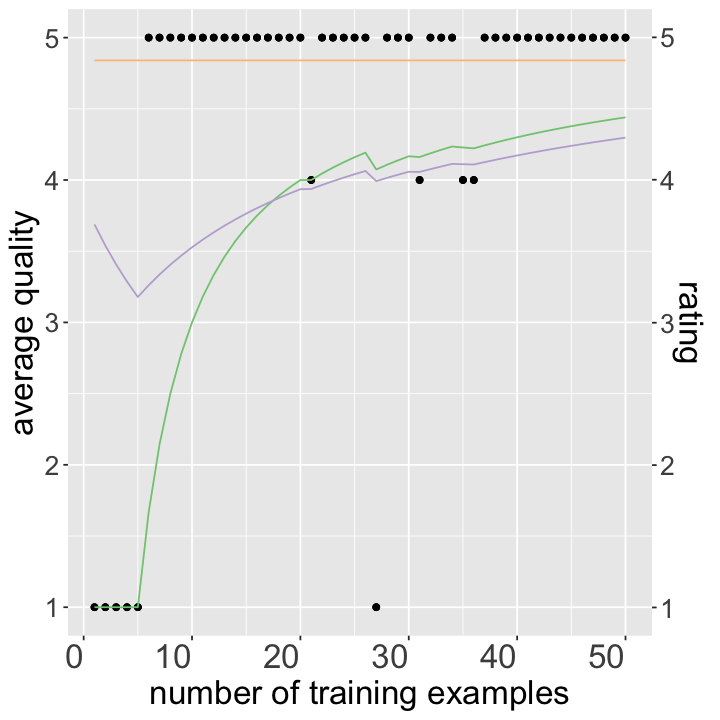

In [38]:
ggplot(df.disp_subset) + 
    geom_point(aes(x=num_train, y=rating)) + 
    geom_line(aes(x=num_train, y=value, colour=method)) +
    scale_y_continuous(
    sec.axis = sec_axis(~ . + 0, name='rating')) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(size=20, angle=0, hjust=1)) +
        xlab("number of training examples") + ylab("average quality") +
    scale_color_brewer(palette="Accent") +
    theme(legend.position = 'none')

In [39]:
df.disp_subset <- arrange(running_avg_df, freq - avg) %>%
                    filter(item=='B00S8IGG4U') %>%
                    arrange(num_train) %>%
                    rename('true average' = avg, 'frequentist' = freq, 'EB' = eb)
setDT(df.disp_subset)
df.disp_subset <- melt(df.disp_subset, 
                         id.vars = c('item', 'num_train', 'n'), 
                         measure.vars = c('frequentist', 'EB', 'true average'),
                         variable.name = 'method')

df.disp_ratings = filter(amazon_df.test_learn_copy, item=='B00S8IGG4U') %>% arrange(timestamp)
df.disp_ratings$num_train = 1:50
df.disp_ratings <- select(df.disp_ratings, c(num_train, rating))

df.disp_subset <- merge(df.disp_subset, df.disp_ratings, by='num_train')

Adding missing grouping variables: `item`



In [40]:
options(repr.plot.width=8, repr.plot.height=6)

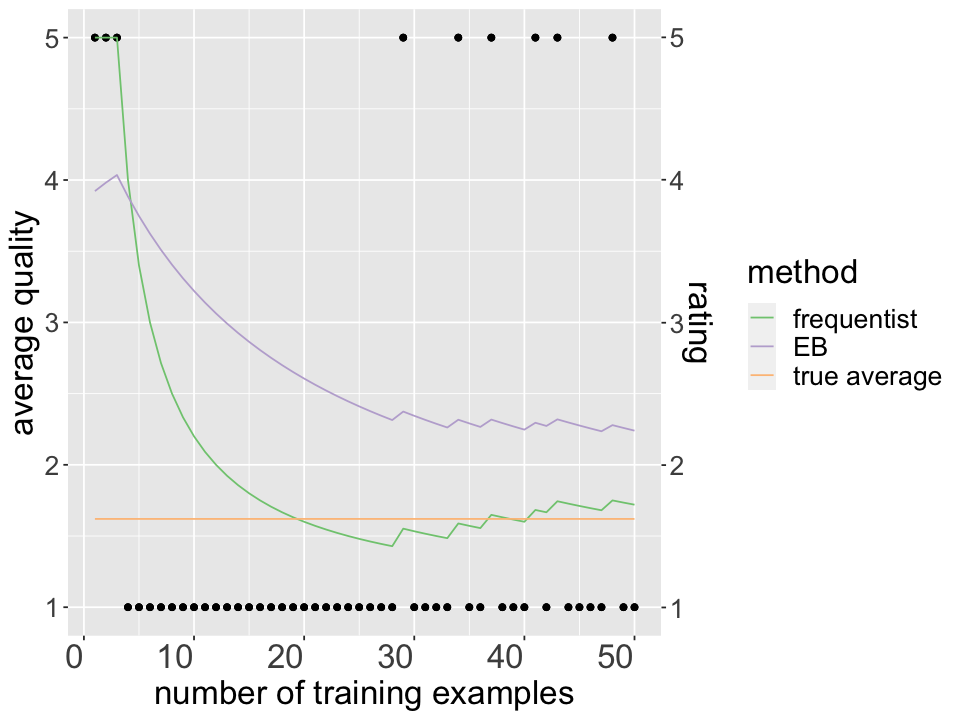

In [41]:
ggplot(df.disp_subset) + 
    geom_point(aes(x=num_train, y=rating)) + 
    geom_line(aes(x=num_train, y=value, colour=method)) +
    scale_y_continuous(
    sec.axis = sec_axis(~ . + 0, name='rating')) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(size=20, angle=0, hjust=1)) +
        xlab("number of training examples") + ylab("average quality") +
    scale_color_brewer(palette="Accent")